In [2]:
import import_ipynb
from generate_false_SOC_VNIR_spectra import *
import matplotlib.pyplot as plt
from scipy import stats

import torch
import torch .nn as nn
import torch .optim as optim

importing Jupyter notebook from generate_false_SOC_VNIR_spectra.ipynb


# Reflectance data analysis, model definition, and regression of pure spectra

## Spectral distance minimization

Below is one computational technique to take advantage of SOC data to identify reflectance troughs which can be associated to SOC absorbance. The methodology involves identifying two spectra which perform a linear combination of the following two tasks:

- (1) Maximize the SOC difference between the reference pedons
- (2) Minimize the number of points between the spectra that differ by 1/2/3 sigma relative to the mean reflectance spectrum

By varying the relative weights of the two cost terms, we can gain insight into the attribution of troughs to specific endmembers, or bonds within the chemical structure of those endmembers.

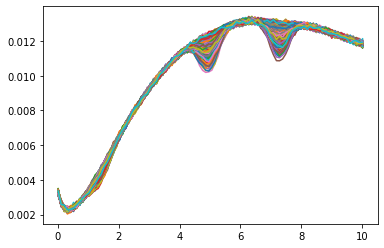

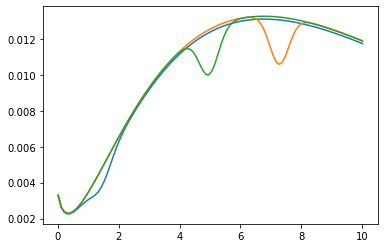

In [3]:
XF, A, F, I, cents = generateFalseData(500,100,3,0.02,0)
plt.plot(XF, I.T)
plt.show()

plt.plot(XF, F.T)
plt.show()

In [870]:
def get_quantile_diff_dist(tI, q) :
    NN = tI.shape[0]
    diffs = np.zeros([int(NN*(NN-1)/2),tI.shape[1]])
    
    ind=0
    for i in range(NN) :
        for j in range(i) :
            diffs[ind,:] = np.abs(tI[i,:] - tI[j,:])
            ind+=1
    
    return np.quantile(diffs, q, axis=0)

In [822]:
def rn(dist) :
    return dist/np.sum(dist,axis=0)

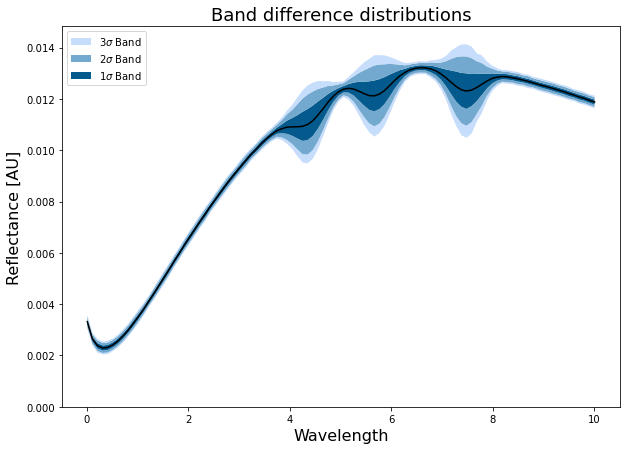

In [888]:
vlamb68 = get_quantile_diff_dist(I,0.68) # 1 sigma
vlamb95 = get_quantile_diff_dist(I,0.95) # 2 sigma
vlamb99 = get_quantile_diff_dist(I,0.99) # 3 sigma

sandplot_y = [np.mean(I,axis=0) - vlamb99, vlamb99 - vlamb95, vlamb95 - vlamb68, 2.0*vlamb68, vlamb95 - vlamb68, vlamb99 - vlamb95]

COLORS = ["#FFFFFF", "#C6DDFB", "#74A9CF", "#045A8D", "#74A9CF", "#C6DDFB"]
fig, ax = plt.subplots(figsize=(10, 7))
ax.stackplot(XF, sandplot_y, colors=COLORS, baseline="zero", labels=[None,'3$\sigma$ Band','2$\sigma$ Band','1$\sigma$ Band']);
plt.plot(XF, np.mean(I, axis=0), 'black')

plt.ylabel('Reflectance [AU]',fontsize=16)
plt.xlabel('Wavelength',fontsize=16)

ax.set_title('Band difference distributions', fontsize=18)
plt.legend(loc='upper left')
plt.show()

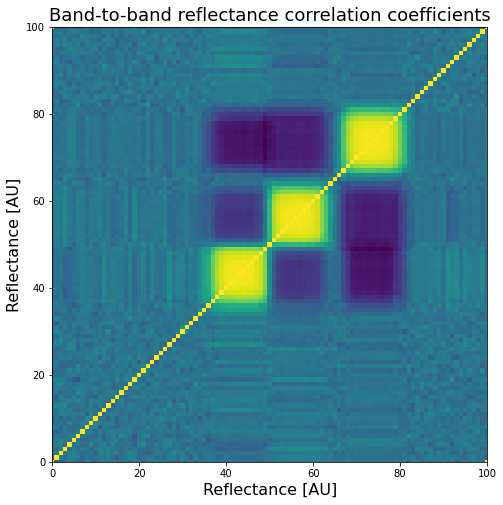

In [918]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.imshow(np.corrcoef(I, I, rowvar = False),interpolation='none')

plt.ylabel('Reflectance [AU]',fontsize=16)
plt.xlabel('Reflectance [AU]',fontsize=16)

ax.set_title('Band-to-band reflectance correlation coefficients', fontsize=18)

plt.xlim([0,100])
plt.ylim([0,100])

plt.show()

In [907]:
def compute_loss(fi,fj,si,sj) :
    tc = (fi-fj)**2
    th = (tc < vlamb95).astype('float')
    tc = np.sum(tc*th)/np.sum(th)
    ts = (si-sj)**2
    
    return tc-ts

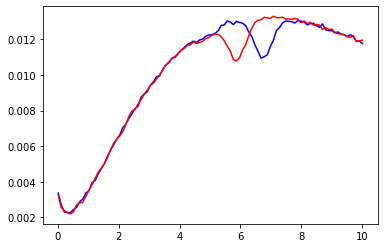

In [805]:
lowest_loss = float('inf')
lowest_loss_i = 0
lowest_loss_j = 1

for i in range(I.shape[0]) :
    for j in range(i) :
        tfi = I[i,:]
        tfj = I[j,:]
        tsi = A[0,i]
        tsj = A[0,j]
        
        tloss = compute_loss(tfi,tfj,tsi,tsj)
        if tloss < lowest_loss :
            lowest_loss = tloss
            lowest_loss_i = i
            lowest_loss_j = j
            
plt.plot(XF, I[lowest_loss_i,:],color='b')
plt.plot(XF, I[lowest_loss_j,:],color='red')
plt.show()

In [794]:
print(cents)

[6.45507177 8.00635973 1.06993127]


In [806]:
print(A[:,lowest_loss_i])
print(A[:,lowest_loss_j])
print(lowest_loss)

[0.84625094 0.13327101 0.02047806]
[1.42776981e-04 1.57510324e-01 8.42346899e-01]
-0.7158990050055569


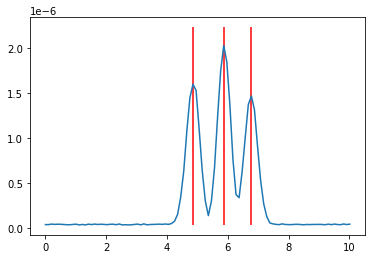

In [826]:
plt.plot(XF, vlamb95)
plt.vlines(x=cents,ymin=min(vlamb95),ymax=max(vlamb95)*1.1, color='r')
plt.show()

## Optimization and Regression

#### TODO: Convert from % by surface area to % by mass (i.e. add model parameters).

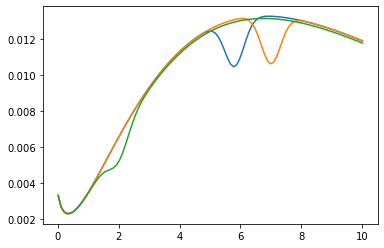

In [881]:
seedAs = torch.tensor((np.ones(A.shape)[1:,:]*(1.0-A[0,:])/(A.shape[0]-1)).tolist())
seedFs = torch.tensor(generatePureFs(100, [5.8,7.0,2.0], noiseV=0, noiseB=0).tolist())
ys = (torch.tensor(A[0,:].tolist()),torch.tensor(I.tolist()),torch.tensor(np.max(I,axis=0).tolist()))

plt.plot(XF, (seedFs.T/torch.sum(seedFs,1)).detach().numpy());

Now, define our initial seed A and F matrices, and prepare our empirical data for regression.

In [ ]:
# seed data: A[1:,:] and initial F's
seedAs = torch.tensor((np.ones(A.shape)[1:,:]*(1.0-A[0,:])/(A.shape[0]-1)).tolist())
seedFs = torch.tensor(generatePureFs(100, [6.5,4.5,0.5], noiseV=0, noiseB=0).tolist())

# empirical data: (SOC values, reflectances, and max normalized reflectance)
ys = (torch.tensor(A[0,:].tolist()),torch.tensor(I.tolist()),torch.tensor(np.max(I,axis=0).tolist()))

Here we define the mixing model in PyTorch. It's a class which tracks model variables, constrains parameters in the loss function, and keeps track of optimization statistics.

In [782]:
class LinearMixingModel(nn.Module):
    def __init__(self, seedF, seedA):
        super().__init__()
        self.fs     = nn.Parameter(seedF)
        self.alphas = nn.Parameter(seedA)
        self.Ihat = 0;
        
        self.lsq = [];
        self.loss = [];
        self.bdsALoss = [];
        self.bdsFLoss = [];
        self.omrsLoss = [];
        self.diffloss1 = [];
        self.difflossfull = [];
        
    def forward(self, y):
        As,Is,Imax = y
        alphFull = torch.transpose(torch.cat((As.unsqueeze(1),torch.transpose(self.alphas,0,1)),dim=1),0,1)
        self.Ihat = torch.matmul(self.fs.T/torch.sum(self.fs,1),alphFull)
                
        # Add in a fake Lagrange multiplier to discourage abundances < 0.01 or > 0.99
        oobsA = torch.sum((-1.0 * (alphFull < 0.01).float() + (alphFull > 0.99).float()) * alphFull)

        # Add in a fake Lagrange multiplier to discourage Fs < 0
        oobsF = -1.0 * torch.sum((self.fs < 0.0).float() * self.fs)

        # Add in a fake Lagrange multiplier to discourage reflectances in F's that are above empirical max
        omrs = torch.sum(((self.fs.T/torch.sum(self.fs,1)).T > Imax.T.repeat(3,1)).float() * ((self.fs.T/torch.sum(self.fs,1)).T - Imax.T.repeat(3,1)))
        
        # Add in 1st derivative loss to smooth the curves
        diffloss = torch.sum(torch.diff(self.fs) ** 2)
        self.diffloss1 += [diffloss];
        
        diffloss += torch.sum(torch.diff(torch.diff(self.fs)) ** 2)
        
        lsq = torch.sum((Is.T - self.Ihat) ** 2)
        loss = lsq * (1 + 10000.0*omrs + 100.0* diffloss + 100.0*oobsA + 1000.0*oobsF)
        
        self.lsq += [lsq]
        self.loss += [loss];
        self.bdsALoss += [oobsA];
        self.bdsFLoss += [oobsF];
        self.omrsLoss += [omrs];
        self.difflossfull += [diffloss];
        
        # Compute the loss function, which is the mean-squared error between data and prediction,
        # with a multiplicative factor for our fake Lagrange multipliers
        return loss

Now, prepare the model and run the optimization.

In [ ]:
model = LinearMixingModel(seedFs,seedAs)
optimizer = optim.Adam(model.parameters(), lr = 0.1)

for epoch in range(200000) :
    loss = model(ys)
    e = torch.mean(loss)
    e.backward()
    optimizer.step()
    optimizer.zero_grad()

    #print("Epoch ",epoch,": ", loss.detach().item())

### Analysis of the output

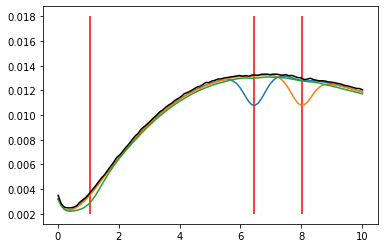

In [783]:
plt.plot(XF, (model.fs.T/torch.sum(model.fs,1)).detach().numpy());
plt.plot(XF, (np.max(I,axis=0)).T,'black');
plt.vlines(cents,0.002,0.018,'r');

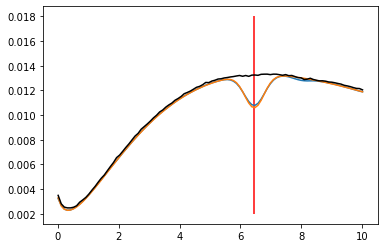

In [784]:
plt.plot(XF, (model.fs.T/torch.sum(model.fs,1)).detach().numpy()[:,0]);
plt.plot(XF, F.T[:,0]);
plt.plot(XF, (np.max(I,axis=0)).T,'black');
plt.vlines(cents[0],0.002,0.018,'r')

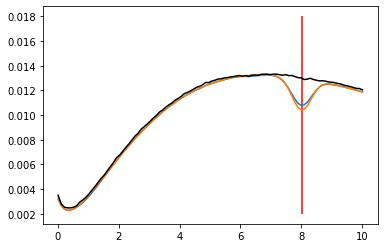

In [785]:
plt.plot(XF, (model.fs.T/torch.sum(model.fs,1)).detach().numpy()[:,1]);
plt.plot(XF, F.T[:,1]);
plt.plot(XF, (np.max(I,axis=0)).T,'black');
plt.vlines(cents[1],0.002,0.018,'r')

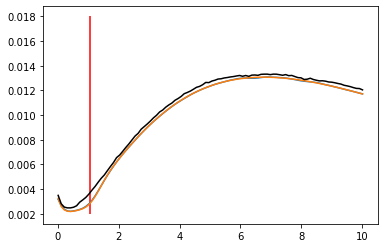

In [786]:
plt.plot(XF, (model.fs.T/torch.sum(model.fs,1)).detach().numpy()[:,2]);
plt.plot(XF, F.T[:,2]);
plt.plot(XF, (np.max(I,axis=0)).T,'black');
plt.vlines(cents[2],0.002,0.018,'r')

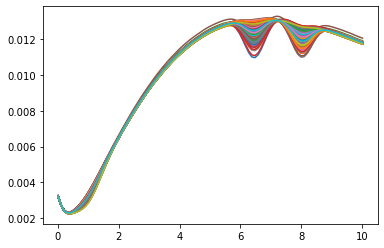

In [787]:
plt.plot(XF, model.Ihat.detach().numpy());

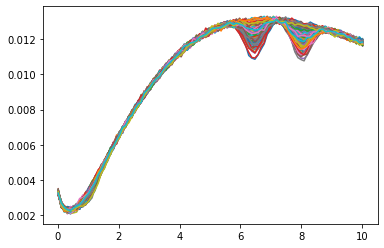

In [788]:
plt.plot(XF, I.T);

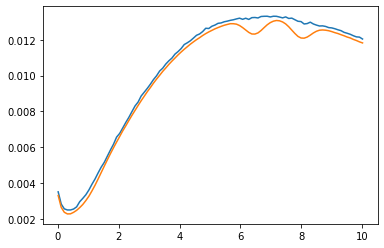

In [789]:
plt.plot(XF, np.max(I,axis=0).T);
plt.plot(XF, np.mean(I,axis=0).T);